[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PetiteIA/schema_mechanism/blob/master/notebooks/agent12.ipynb)

# L'AGENT QUI PRENAIT DU RECUL

Nous allons doter l'Agent12 d'une Long Short Term Memory (LSTM) pour modéliser les séquences apprises. 
Nous allons visualiser l'espace d'embedding de la LSTM pour voir comment ce modèle représente les interactions. 

Le fait que certaines interactions se retrouvent regroupées dans l'espace lattent indique que l'agent a appris à leur accorder un sens similaire. 

Cette analyse constitue une contribution au champ de recherche en "experience-grounding semantics" (e.g., [Pei Wang, 2005](https://www.sciencedirect.com/science/article/abs/pii/S1389041704000373)). 
Elle montre de manière graphique que l'agent attribue de lui-même une signification aux interactions alors qu'il ignorait leur significations au départ. 

In [ ]:
# Outils de visualisation de points 3D

!pip install plotly

# Préparons les classes CompositeInteraction et Interaction

Nous conservons la même classe `CompositeInteraction` que l'Agent11 sauf que nous ajoutons la méthode `series()` qui renvoie la séquence des tokens des interactions primitive sous forme d'une liste de tokens.

Les tokens sont construits par `action * BASE + outcome`.

In [14]:
BASE = 2

In [15]:
class CompositeInteraction:
    """A composite interaction is a tuple (pre_interaction, post_interaction) and a weight"""
    def __init__(self, pre_interaction, post_interaction):
        self.pre_interaction = pre_interaction
        self.post_interaction = post_interaction
        self.weight = 1
        self._step = 1

    def get_decision(self):
        """Return the flatten sequence of intermediary primitive interactions terminated with the final decision"""
        return f"{self.pre_interaction.sequence()}{self.post_interaction.get_decision()}"

    def get_actions(self):
        """Return the flat sequence of the decisions of this interaction as a string"""
        return f"{self.pre_interaction.get_actions()}{self.post_interaction.get_actions()}"
    
    def get_valence(self):
        """Return the valence of the pre_interaction plus the valence of the post_interaction"""
        return self.pre_interaction.get_valence() + self.post_interaction.get_valence()

    def reinforce(self):
        """Increment the composite interaction's weight"""
        self.weight += 1

    def key(self):
        """ The key to find this interaction in the dictionary is the string '<pre_interaction><post_interaction>'. """
        return f"({self.pre_interaction.key()},{self.post_interaction.key()})"

    def pre_key(self):
        """Return the key of the pre_interaction"""
        return self.pre_interaction.key()

    def __str__(self):
        """ Print the interaction in the Newick tree format (pre_interaction, post_interaction: valence) """
        return f"({self.pre_interaction}, {self.post_interaction}: {self.weight})"

    def __eq__(self, other):
        """ Interactions are equal if they have the same pre and post interactions """
        if isinstance(other, self.__class__):
            return (self.pre_interaction == other.pre_interaction) and (self.post_interaction == other.post_interaction)
        else:
            return False

    def get_length(self):
        """Return the length of the number of primitive interactions in this composite interaction"""
        return self.pre_interaction.get_length() + self.post_interaction.get_length()

    def increment(self, interaction, interactions):
        """Increment the step of the appropriate sub-interaction. Return the enacted interaction if it is over, or None if it is ongoing."""
        # First step 
        if self._step == 1:
            interaction = self.pre_interaction.increment(interaction, interactions)
            # Ongoing pre-interaction. Return None
            if interaction is None:
                return None
            # Pre-interaction succeeded. Increment the step and return None
            elif interaction == self.pre_interaction:
                self._step = 2
                return None
            # Pre-interaction failed. Reset the step and return the enacted interaction
            else:
                self._step = 1
                return interaction
        # Second step
        else:
            interaction = self.post_interaction.increment(interaction, interactions)
            # Ongoing post-interaction. Return None
            if interaction is None:
                return None
            # Post-interaction succeeded. Reset the step and return this interaction
            elif interaction == self.post_interaction:
                self._step = 1
                return self
            # Post-interaction failed. Reset the step and return the enacted interaction
            else:
                self._step = 1
                composite_interaction = CompositeInteraction(self.pre_interaction, interaction)
                if composite_interaction.key() not in interactions:
                    # Add the enacted composite interaction to memory
                    interactions[composite_interaction.key()] = composite_interaction
                    print(f"Learning {composite_interaction}")
                    return composite_interaction
                else:
                    # Reinforce the existing composite interaction and return it
                    interactions[composite_interaction.key()].reinforce()
                    print(f"Reinforcing {interactions[composite_interaction.key()]}")
                    return interactions[composite_interaction.key()]

    def current(self):
        """Return the current intended primitive interaction"""
        # Step 1: the current primitive interaction of the pre-interaction
        if self._step == 1:
            return self.pre_interaction.current()
        # Step 2: The current primitive interaction of the post-interaction
        else:
            return self.post_interaction.current()

    def sequence(self):
        """Return the flat sequence of primitive interactions of this composite interaction"""
        return f"{self.pre_interaction.sequence()}{self.post_interaction.sequence()}"

    def get_post_interactions(self):
        """Return the list of the hierarchy of the sub post_interactions"""
        return [self.post_interaction] + self.post_interaction.get_post_interactions()

    def series(self):
        """Return the series of tokens of the primitive interactions"""
        series = self.pre_interaction.series()
        series.extend(self.post_interaction.series())
        return series
        

Nous conservons la mêmes classe `Interaction ` que pour l'Agent10 a part la méthode `get_post_interactions()` ajoutée. 

In [16]:
class Interaction:
    """An interaction is a tuple (action, outcome) with a valence"""
    def __init__(self, _action, _outcome, _valence):
        self._action = _action
        self._outcome = _outcome
        self._valence = _valence
        self.weight = 10
        
    def get_action(self):
        """Return the action"""
        return self._action

    def get_actions(self):
        """Return the action as a string for compatibilty with CompositeInteraction"""
        return str(self._action)

    def get_decision(self):
        """Return the decision key"""
        return f"{self._action}"
        # return f"a{self._action}"

    def get_outcome(self):
        """Return the action"""
        return self._outcome

    def get_valence(self):
        """Return the action"""
        return self._valence

    def key(self):
        """ The key to find this interaction in the dictinary is the string '<action><outcome>'. """
        return f"{self._action}{self._outcome}"

    def pre_key(self):
        """Return the key. Used for compatibility with CompositeInteraction"""
        return ""  # self.key()

    def __str__(self):
        """ Print interaction in the form '<action><outcome:<valence>' for debug."""
        return f"{self._action}{self._outcome}:{self._valence}"

    def __eq__(self, other):
        """ Interactions are equal if they have the same key """
        if isinstance(other, self.__class__):
            return self.key() == other.key()
        else:
            return False

    def get_length(self):
        """The length of the sequence of this interaction"""
        return 1

    def increment(self, interaction, interactions):
        """Return the enacted interaction for compatibility with composite interactions"""
        return interaction

    def current(self):
        """Return itself for compatibility with composite interactions"""
        return self

    def sequence(self):
        """Return the key. Use for compatibility with composite interactions"""
        return self.key()

    def get_post_interactions(self):
        """Return the empty list for compatibility with composite interactions"""
        return []

    def series(self):
        """Return the token of this primitive interactions in a list"""
        return [self._action * BASE + self._outcome]


# Implémententons le modèle LSTM

In [17]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.len_vocab = 12
        self.num_layers = 1
        self.hidden_size = 64

        embedding_dim = 3  # self.len_vocab   On force in embedding à 3 dimensions
        # Create an embedding layer to convert token indices to dense vectors
        self.embedding = nn.Embedding(self.len_vocab, embedding_dim )
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        
        # Define the output fully connected layer
        self.fc_out = nn.Linear(self.hidden_size, self.len_vocab)

        self._optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=0.0001)
        self._loss_func = nn.CrossEntropyLoss()

        # Initialize the weights
        # Embedding
        # nn.init.constant_(self.embedding.weight, 0.5)  # Exemple : tous les poids à 0.5
        # Initialisation manuelle des poids et biais du LSTM
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)  # ou utilisez .copy_() pour valeurs fixes
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)
        # Initialisation du fully connected
        #nn.init.zeros_(self.fc_out.weight)
        nn.init.constant_(self.fc_out.weight, 0.5)
        nn.init.constant_(self.fc_out.bias, 0.1)
    
    def forward(self, input_seq, hidden_in, mem_in):
        # Convert token indices to dense vectors
        input_embs = self.embedding(input_seq)
        # input_embs = input_seq.type(torch.float32)

        # Pass the embeddings through the LSTM layer
        output, (hidden_out, mem_out) = self.lstm(input_embs, (hidden_in, mem_in))
                
        # Pass the LSTM output through the fully connected layer to get the final output
        return self.fc_out(output), hidden_out, mem_out

    def fit(self, inputs, targets):

        input_tensor = torch.tensor(inputs) # , dtype=torch.int)
        # print("input tensor", input_tensor)
        labels = torch.tensor(targets)
        # print("label tensor", labels)
        
        # Loop through each epoch
        for epoch in range(20):    
            # Set model to training mode
            self.train()
            train_acc = 0
    
            # Initialize hidden and memory states
            hidden = torch.zeros(self.num_layers, input_tensor.shape[0], self.hidden_size, device="cpu")
            memory = torch.zeros(self.num_layers, input_tensor.shape[0], self.hidden_size, device="cpu")
    
            # Forward pass through the model
            pred, hidden, memory = self(input_tensor, hidden, memory)

            # Calculate the loss
            loss = self._loss_func(pred[:, -1, :], labels)
        
            # Backpropagation and optimization
            self._optimizer.zero_grad()
            loss.backward()
            self._optimizer.step()
    
            # Append training loss to logger
            # training_loss_logger.append(loss.item())
    
            # Calculate training accuracy
            train_acc += (pred[:, -1, :].argmax(1) == labels).sum()
        print(f"acc : {train_acc/len(labels):.3f} = {train_acc}/{len(labels)} for epoch {epoch}")

    def predict(self, sequence):
        # Construct the context sequence
        sequence = torch.tensor(sequence, dtype=torch.float)

        h = torch.zeros(self.num_layers, sequence.shape[0], self.hidden_size, device="cpu")
        cell = torch.zeros(self.num_layers, sequence.shape[0], self.hidden_size, device="cpu")
        
        with torch.no_grad():  # Pas de calcul de gradients en mode prédiction
            logits, _, _ = self(sequence, h, cell)
        ## probabilities = nn.functional.softmax(logits[0, -1, :], dim=0).tolist()
        # Compute the probability of each outcome for each action
        pairwise_logits = logits[0, -1, :].reshape(-1, 2)
        probabilities = nn.functional.softmax(pairwise_logits, dim=1).flatten().tolist()
        # print("probabilities", probabilities)
        return probabilities
    

# Implémentons l'agent 

Nous ajoutons une méthode qui estime la `expected_valence` sur la base du LSTM.

In [18]:
import pandas as pd

class Agent:
    def __init__(self, _interactions):
        """ Initialize our agent """
        # Initialise le réseau de neurone
        self._lstm = LSTM()
        # Les intéreactions doivent être triées dans l'ordre de leurs tokens
        self._interactions = dict(sorted({interaction.key(): interaction for interaction in _interactions}.items()))
        self._primitive_intended_interaction = self._interactions["00"]
        self._intended_interaction = None

        # The context
        self._penultimate_interaction = None
        self._previous_interaction = None
        self._last_interaction = None
        self._penultimate_composite_interaction = None
        self._previous_composite_interaction = None
        self._last_composite_interaction = None
        
        # Prepare the dataframe of proposed interactions
        default_interactions = [interaction for interaction in _interactions if interaction.get_outcome() == 0]
        data = {'activated': [""] * len(default_interactions),
                'weight': [0] * len(default_interactions),
                'actions': [i.get_actions() for i in default_interactions],
                'intention': [i.key() for i in default_interactions],
                'valence': [i.get_valence() for i in default_interactions],
                'decision': [i.get_decision() for i in default_interactions],
                'length': [1] * len(default_interactions),
                'pre': [""] * len(default_interactions)} 
        self._default_df = pd.DataFrame(data)
        self.proposed_df = None
        self.decision_df = None
        self.clear = True # Used to clear the display after the enacted interaction

    def action(self, _outcome):
        """Implement the agent's policy"""
        # Trace the previous cycle
        primitive_enacted_interaction = self._interactions[f"{self._primitive_intended_interaction.get_action()}{_outcome}"]
        print(
            f"Action: {self._primitive_intended_interaction.get_action()}, Prediction: {self._primitive_intended_interaction.get_outcome()}, "
            f"Outcome: {_outcome}, Prediction_correct: {self._primitive_intended_interaction.get_outcome() == _outcome}, "
            f"Valence: {primitive_enacted_interaction.get_valence()}")

        # Follow up the enaction
        if self._intended_interaction is None: # First interaction cycle
            enacted_interaction = primitive_enacted_interaction
        else:
            enacted_interaction = self._intended_interaction.increment(primitive_enacted_interaction, self._interactions)

        # If the intended interaction is over (completely enacted or aborted)
        if enacted_interaction is None:
            self.clear = False
        else:
            self.clear = True
            # Memorize the context
            self._penultimate_composite_interaction = self._previous_composite_interaction
            self._previous_composite_interaction = self._last_composite_interaction
            self._penultimate_interaction = self._previous_interaction
            self._previous_interaction = self._last_interaction
            self._last_interaction = enacted_interaction
            # Call the learning mechanism
            self.learn(enacted_interaction)
            self.train()
            # Create the proposed dataframe
            self.create_proposed_df()
            self.aggregate_propositions()
            # Decide the next enaction
            self.decide()

        # Return the next primitive action
        self._primitive_intended_interaction = self._intended_interaction.current()
        return self._primitive_intended_interaction.get_action()
        
    def learn(self, enacted_interaction):
        """Learn the composite interactions"""
        # First level of composite interactions
        self._last_composite_interaction = self.learn_composite_interaction(self._previous_interaction, enacted_interaction)
        # Second level of composite interactions
        self.learn_composite_interaction(self._previous_composite_interaction, enacted_interaction)
        self.learn_composite_interaction(self._penultimate_interaction, self._last_composite_interaction)

        # Higher level composite interaction made of two composite interactions
        if self._last_composite_interaction is not None:
            self.learn_composite_interaction(self._penultimate_composite_interaction, self._last_composite_interaction)

    def learn_composite_interaction(self, pre_interaction, post_interaction):
        """Record or reinforce the composite interaction made of (pre_interaction, post_interaction)"""
        if pre_interaction is None:
            return None
        else:
            # If the pre-interaction exists
            composite_interaction = CompositeInteraction(pre_interaction, post_interaction)
            if composite_interaction.key() not in self._interactions:
                # Add the composite interaction to memory
                self._interactions[composite_interaction.key()] = composite_interaction
                print(f"Learning {composite_interaction}")
                return composite_interaction
            else:
                # Reinforce the existing composite interaction and return it
                self._interactions[composite_interaction.key()].reinforce()
                print(f"Reinforcing {self._interactions[composite_interaction.key()]}")
                return self._interactions[composite_interaction.key()]

    def create_proposed_df(self):
        """Create the proposed dataframe from the activated interactions"""
        # The list of activated interactions that match the current context
        activated_interactions = [i for i in self._interactions.values() if i.get_length() > 1 
                                  and i.pre_interaction in self._last_composite_interaction.get_post_interactions()]
        data = {'activated': [i.key() for i in activated_interactions],
                'weight': [i.weight for i in activated_interactions],
                'actions': [i.post_interaction.get_actions() for i in activated_interactions],
                'intention': [i.post_interaction.key() for i in activated_interactions],
                'valence': [i.post_interaction.get_valence() for i in activated_interactions],
                'decision': [i.post_interaction.get_decision() for i in activated_interactions],
                'pre': [i.post_interaction.pre_key() for i in activated_interactions],
                'length': [i.post_interaction.get_length() for i in activated_interactions],
                }
        activated_df = pd.DataFrame(data).astype(self._default_df.dtypes)  # Force the same types in case activated_df is empty

        # Create the proposed dataframe
        self.proposed_df = pd.concat([self._default_df, activated_df], ignore_index=True).sort_values(by='decision', ascending=True).reset_index(drop=True)

        # Calculate the proclivity of each proposition
        self.proposed_df['proclivity'] = self.proposed_df['weight'] * self.proposed_df['valence']

        # Compute the probability of each propositions
        # self.proposed_df['probability'] = self.proposed_df['weight'] / self.proposed_df.groupby('actions')['weight'].transform('sum')
        self.proposed_df['probability'] = self.proposed_df.groupby('intention')['weight'].transform('sum') / self.proposed_df.groupby('actions')['weight'].transform('sum')

    def aggregate_propositions(self):
        """Aggregate the proclivity"""
        # Aggregate the proclivity for each decision
        grouped_df = self.proposed_df.groupby('decision').agg({'proclivity': 'sum', 'actions': 'first', # 'action': 'first', 
                                                               'length': 'first', 'intention': 'first', 'pre': 'first'}).reset_index()
        # For each proposed composite decision 
        for index, proposed in grouped_df[grouped_df['length'] > 1].iterrows():
            # print(f"Index {index}, actions {proposition['actions']}, intention {proposition['intention']}")
            # Find shorter decisions that start with the same sequence 
            for _, shorter in self.proposed_df[self.proposed_df.apply(lambda row: proposed['actions'].startswith(row['actions']) 
                                                                      and row['length'] < proposed['length'], axis=1)].iterrows():
                # Add the proclivity of the shorter decisions
                grouped_df.loc[index, 'proclivity'] += shorter['proclivity']
                # print(f"Decision {proposed['decision']} recieves {shorter['proclivity']} from shorter {shorter['intention']}")
        
        # Sort by descending proclivity
        self.decision_df = grouped_df.sort_values(by=['proclivity', 'decision'], ascending=[False, True]).reset_index(drop=True)

    def decide(self):
        """Selects the intended_interaction at the top of the proposed dataframe"""
        # The intended interaction is in the first row because it has been sorted by descending proclivity
        intended_interaction_key = self.decision_df.loc[0, 'intention']
        print("Intention:", intended_interaction_key)
        self._intended_interaction = self._interactions[intended_interaction_key]

    def train(self):
        """Train the LSTM Model"""
        return

# L'environnement SmallLoop 

In [19]:
save_dir = "sav"

FORWARD = 0
FEEL_FRONT = 1
FEEL_LEFT = 2
FEEL_RIGHT = 3
TURN_LEFT = 4
TURN_RIGHT = 5

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from ipywidgets import Button, HBox,VBox, Output
from IPython.display import display

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
FEELING_EMPTY = 2
FEELING_WALL = 3
BUMPING = 4

colors = ["#b0b0b0", '#b0b0b0', '#ffffff', '#535865', "#F93943"]  # Hidden environment
colors = ["#D6D6D6", '#5C946E', '#FAE2DB', '#535865', "#F93943"]
agent_color = "#1976D2"

class SmallLoop():
    def __init__(self, position, direction):
        self.grid = np.array([
            [1, 1, 1, 1, 1, 1], 
            [1, 0, 0, 0, 1, 1],
            [1, 0, 1, 0, 0, 1],
            [1, 0, 1, 1, 0, 1],
            [1, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1]
        ])
        self.maze = self.grid.copy()
        self.position = np.array(position) 
        self.direction = direction
        self.cmap = ListedColormap(colors)
        self.norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], self.cmap.N)
        self.marker_size = 400
        self.marker_map = {LEFT: '<', DOWN: 'v', RIGHT: '>', UP: '^'}
        self.marker_color = agent_color
        self.directions = np.array([
            [0, -1],  # Left
            [1, 0],   # Down
            [0, 1],   # Right
            [-1, 0]   # Up
            ])

    def outcome(self, action):
        """Update the grid. Return the outcome of the action."""
        result = 0
        # x, y = self.position

        if action == FORWARD:  
            target_position = self.position + self.directions[self.direction]
            if self.grid[tuple(target_position)] == 0:
                self.position[:] = target_position
            else:
                result = 1
                self.maze[tuple(target_position)] = BUMPING
        
        elif action == TURN_RIGHT:
            self.direction = {LEFT: UP, DOWN: LEFT, RIGHT: DOWN, UP: RIGHT}[self.direction]
        
        elif action == TURN_LEFT:
            self.direction = {LEFT: DOWN, DOWN: RIGHT, RIGHT: UP, UP: LEFT}[self.direction]
        
        elif action == FEEL_FRONT:
            feeling_position = self.position + self.directions[self.direction]
            if self.grid[tuple(feeling_position)] == 0:
                self.maze[tuple(feeling_position)] = FEELING_EMPTY
            else:
                result = 1
                self.maze[tuple(feeling_position)] = FEELING_WALL
        
        elif action == FEEL_LEFT:
            feeling_position = self.position + self.directions[(self.direction + 1) % 4]
            if self.grid[tuple(feeling_position)] == 0:
                self.maze[tuple(feeling_position)] = FEELING_EMPTY
            else:
                result = 1
                self.maze[tuple(feeling_position)] = FEELING_WALL
        
        elif action == FEEL_RIGHT:
            feeling_position = self.position + self.directions[self.direction - 1]
            if self.grid[tuple(feeling_position)] == 0:
                self.maze[tuple(feeling_position)] = FEELING_EMPTY
            else:
                result = 1
                self.maze[tuple(feeling_position)] = FEELING_WALL

        print(f"Line: {self.position[0]}, Column: {self.position[1]}, direction: {self.direction}")
        return result  
    
    def display(self):
        """Display the grid in the notebook"""
        out.clear_output(wait=True)
        with out:
            fig, ax = plt.subplots()
            ax.imshow(self.maze, cmap=self.cmap, norm=self.norm)
            plt.scatter(self.position[1], self.position[0], s=self.marker_size, marker=self.marker_map[self.direction], c=self.marker_color)
            ax.text(4.5, 0, f"{step:>3}", fontsize=12, color='White')
            plt.show()
    
    def save(self, step):
        """Save the display as a PNG file"""
        fig, ax = plt.subplots()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
        ax.imshow(self.maze, cmap=self.cmap, norm=self.norm)
        plt.scatter(self.position[1], self.position[0], s=self.marker_size, marker=self.marker_map[self.direction], c=self.marker_color)
        ax.text(4.5, 0, f"{step:>4}", fontsize=12, color='White')
        plt.savefig(f"{save_dir}/{step:04}.png", bbox_inches='tight', pad_inches=0, transparent=True)
        plt.close(fig)
    
    def clear(self, clear):
        """Clear the grid display"""
        if clear:
            self.maze[:, :] = self.grid


# Testons l'agent dans le Small Loop

In [21]:
# Instanciate the small loop environment
e = SmallLoop([1, 1], 0)

# Instanciate the agent 
interactions = [
    Interaction(FORWARD,0,5),
    Interaction(FORWARD,1,-10),
    Interaction(TURN_LEFT,0,-3),
    Interaction(TURN_LEFT,1,-3),
    Interaction(TURN_RIGHT,0,-3),
    Interaction(TURN_RIGHT,1,-3),
    Interaction(FEEL_FRONT,0,-1),
    Interaction(FEEL_FRONT,1,-1),
    Interaction(FEEL_LEFT,0,-1),
    Interaction(FEEL_LEFT,1,-1),
    Interaction(FEEL_RIGHT,0,-1),
    Interaction(FEEL_RIGHT,1,-1)
]
a = Agent(interactions)

# Initialize the interaction loop
step = 0
outcome = 0

# Display
out = Output()
e.display()
display(out)

Output()

In [288]:
print(f"Step: {step}")
step += 1
action = a.action(outcome)
e.display()
e.save(step)  # Save the image file 
e.clear(a.clear)  # Clear the display grid if the current composite enaction is over
outcome = e.outcome(action)
a.proposed_df

Step: 266
Action: 1, Prediction: 0, Outcome: 0, Prediction_correct: True, Valence: -1
Line: 4, Column: 3, direction: 0


,activated,weight,actions,intention,valence,decision,length,pre,proclivity,probability
0,,0,0,00,5,0,1,,0,0.000000
1,"(11,01)",1,0,01,-10,0,1,,-10,1.000000
2,"(11,(01,20))",1,02,"(01,20)",-11,012,2,01,-11,1.000000
3,,0,1,10,-1,1,1,,0,0.000000
4,"(11,11)",3,1,11,-1,1,1,,-3,1.000000
5,"(11,(11,21))",2,12,"(11,21)",-2,112,2,11,-4,0.666667
6,"(11,(11,20))",1,12,"(11,20)",-2,112,2,11,-2,0.333333
7,"(11,21)",2,2,21,-1,2,1,,-2,0.666667
8,,0,2,20,-1,2,1,,0,0.333333
9,"(11,20)",1,2,20,-1,2,1,,-1,0.333333


# Créons l'Agent 12

Nous créons la méthode `train` pour entrainer le LSTM avec des séquences construites à partir des interactions composites apprises. 

In [9]:
class Agent12(Agent):
    def train(self):
        """Entrain le LSTM avec toutes les interactions composite"""
        # Pour toutes les interactions composite jusqu'a la longuer 6
        for l in range(2, 7):
            x = [i.series()[:-1] for i in self._interactions.values() if i.get_length() == l]
            print("x", x)
            y = [i.series()[-1] for i in self._interactions.values() if i.get_length() == l]
            print("y", y)
            if len(x) > 0:
                self._lstm.fit(x, y)


# Testons l'Agent12 dans le Small Loop

In [10]:
torch.manual_seed(42)

# Instanciate the small loop environment
e = SmallLoop([1, 1], 0)

# Instanciate the agent 
interactions = [
    Interaction(FORWARD,0,5),
    Interaction(FORWARD,1,-10),
    Interaction(TURN_LEFT,0,-3),
    Interaction(TURN_LEFT,1,-3),
    Interaction(TURN_RIGHT,0,-3),
    Interaction(TURN_RIGHT,1,-3),
    Interaction(FEEL_FRONT,0,-1),
    Interaction(FEEL_FRONT,1,-1),
    Interaction(FEEL_LEFT,0,-1),
    Interaction(FEEL_LEFT,1,-1),
    Interaction(FEEL_RIGHT,0,-1),
    Interaction(FEEL_RIGHT,1,-1)
]
a = Agent12(interactions)

# Initialize the interaction loop
step = 0
outcome = 0

# Display
out = Output()
e.display()
display(out)

Output()

In [289]:
print(f"Step: {step}")
step += 1
action = a.action(outcome)
e.display()
e.save(step)  # Save the image file 
e.clear(a.clear)  # Clear the display grid if the current composite enaction is over
outcome = e.outcome(action)
a.proposed_df

Step: 267
Action: 0, Prediction: 0, Outcome: 0, Prediction_correct: True, Valence: 5
Line: 4, Column: 3, direction: 0


,activated,weight,actions,intention,valence,decision,length,pre,proclivity,probability
0,,0,0,00,5,0,1,,0,0.000000
1,"(11,01)",1,0,01,-10,0,1,,-10,1.000000
2,"(11,(01,20))",1,02,"(01,20)",-11,012,2,01,-11,1.000000
3,,0,1,10,-1,1,1,,0,0.000000
4,"(11,11)",3,1,11,-1,1,1,,-3,1.000000
5,"(11,(11,21))",2,12,"(11,21)",-2,112,2,11,-4,0.666667
6,"(11,(11,20))",1,12,"(11,20)",-2,112,2,11,-2,0.333333
7,"(11,21)",2,2,21,-1,2,1,,-2,0.666667
8,,0,2,20,-1,2,1,,0,0.333333
9,"(11,20)",1,2,20,-1,2,1,,-1,0.333333


# Visualisation

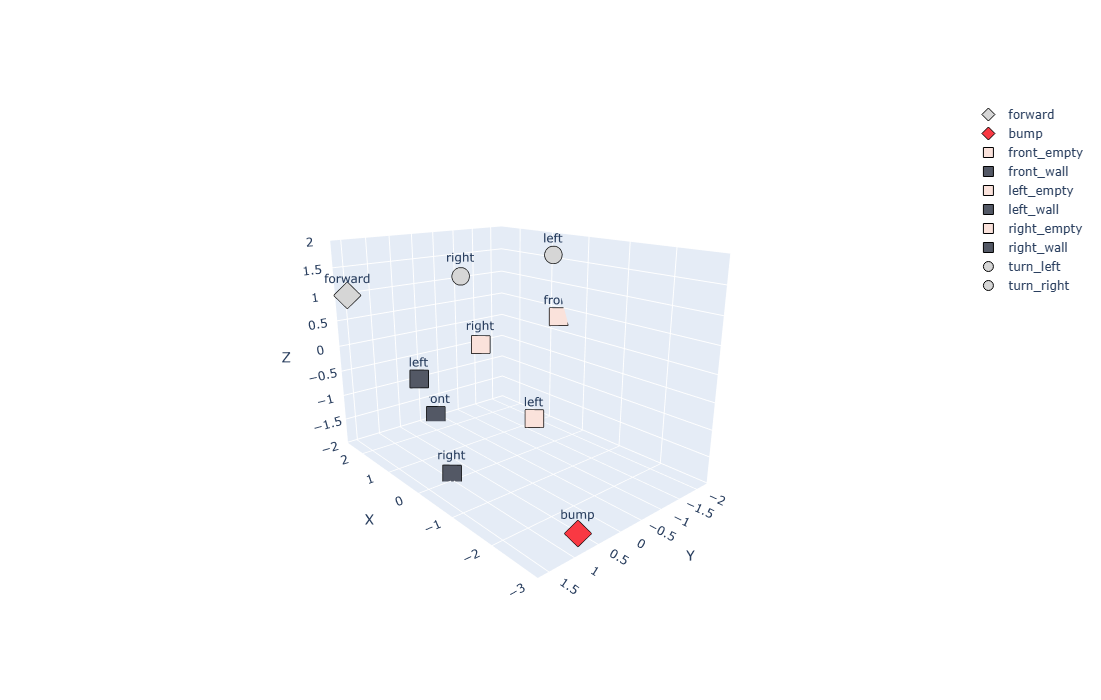

In [262]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

# Liste de formes de marqueurs disponibles dans Plotly
marker_symbols = ['diamond', 'diamond', 'square', 'square', 'square', 'square','square', 'square', 'circle', 'cross', 'circle', 'cross']
# Couleurs (différentes pour chaque token)
marker_colors = ['#D6D6D6', '#F93943', '#FAE2DB', '#535865', '#FAE2DB', '#535865', '#FAE2DB', '#535865', '#D6D6D6', '#D6D6D6', '#D6D6D6', '#D6D6D6']

def plotly_embedding(agent):
    # Extraire les vecteurs d'embedding
    embedding_weights = agent._lstm.embedding.weight.data        
    # Récupérer les coordonnées
    x = embedding_weights[:, 0].numpy()
    y = embedding_weights[:, 1].numpy()
    z = embedding_weights[:, 2].numpy()
    labels = ['forward', 'bump', 'front_empty', 'front_wall', 'left_empty', 'left_wall','right_empty', 'right_wall', 'turn_left', 'turn_left', 'turn_right', 'turn_righ']
    tags = ['forward', 'bump', 'front', 'front', 'left', 'left','right', 'right', 'left', '', 'right', '']
    #labels = [f"Token {i}" for i in range(agent._lstm.len_vocab)]
    # Créer une figure Plotly
    fig = go.Figure()
    
    for i in range(agent._lstm.len_vocab):
        # Exclude the turn wall interactions
        if i in [9, 11]:
            continue
        fig.add_trace(go.Scatter3d(
            x=[x[i]],
            y=[y[i]],
            z=[z[i]],
            mode='markers+text',
            name=labels[i],
            marker=dict(
                size=10,
                color=marker_colors[i],
                symbol=marker_symbols[i],
                line=dict(width=1, color='black')
            ),
            text= tags[i],
            textposition='top center'
        ))    
    fig.update_layout(
        # title='Visualisation 3D des embeddings',
        width=900,
        height=700,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        )
    )  
    # Affichage interactif
    fig.show(config={"toImageButtonOptions": {"format": "svg"}}) # Spécifie le format de sauvegarde associé au bouton "download" 

plotly_embedding(a)

Dans certains cas, on peut voir des regroupements significatifs des interactions, comme par exemple dans la Figure1 ou les interactions `feel_wall` et `feel_empty` sont regroupées entre elles. 
Cependant ces regroupement n'apparaissent pas à chaque fois.

![Figure 1](img/embedding.svg)

_Figure 1: Exemple de visualisation des embeddings._

Les interactions qui déplacent l'agent ("forward" et "turn") sont regroupées en haut à gauche.
Les interactions "feel_wall" sont au centre gauche, "feel_empty" au centre droit, et l'interaction "bump" est isolée en bas à droite. 
En revanche, les interactions ne sont pas regroupé par coté de l'agent (sa gauche ou sa droite). 

# Analyse

L'apprentissage est meilleur si on le fait à chaque cycle plutot qu'une fois à la fin

Il faudrait essayer avec un transformer plutot qu'un LSTM

# Extrayons les séquences apprises 

In [ ]:
# Le token End Of Sequence = 11
EOS_TOKEN = 11

def sequences(agent):
    """Entraine le LSTM avec toutes les interactions composite"""
    # Pour toutes les interactions composite jusqu'a la longuer 6
    print("Sequences to train the LSTM:")
    for l in range(2, 7):
        x = [i.series()[:-1] for i in agent._interactions.values() if i.get_length() == l]
        # print("x", x)
        y = [i.series()[-1] for i in agent._interactions.values() if i.get_length() == l]
        # print("y", y)

    print("Sequences to train the next token prediction Transformer:")
    # for l in range(2, 7):
        # print([i.series() for i in agent._interactions.values() if i.get_length() == l])

    print("Sequences to train the seq2seq Transformer:")
    # for l in range(2, 20):
    #     print([[i.pre_interaction.series(), i.post_interaction.series()] for i in agent._interactions.values() if i.get_length() == l], ",")
    print([[i.pre_interaction.series(), i.post_interaction.series()] for i in agent._interactions.values() for l in range(10, 20) if i.get_length() == l ])

sequences(a)